In [1]:
!unzip bust.zip

Archive:  bust.zip
replace bust/B21.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bust/B22.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bust/B23.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bust/B24.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bust/B25.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
!pip install open3d

n


In [3]:
import os
import cv2
import numpy as np
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [4]:
images_folder = '/content/bust'
image_paths = sorted(glob(os.path.join(images_folder, '*.jpg')))
images = [cv2.imread(img_path) for img_path in image_paths]


<ipython-input-5-c75c2a2f5cf0>:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_bytes = cv2.imencode('.png', img)[1].tostring()


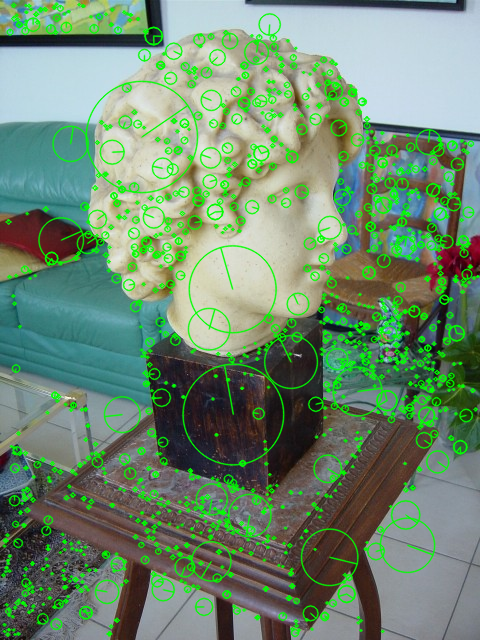

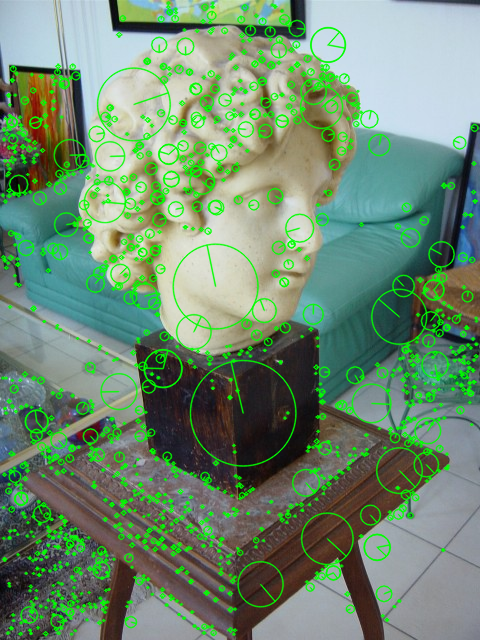

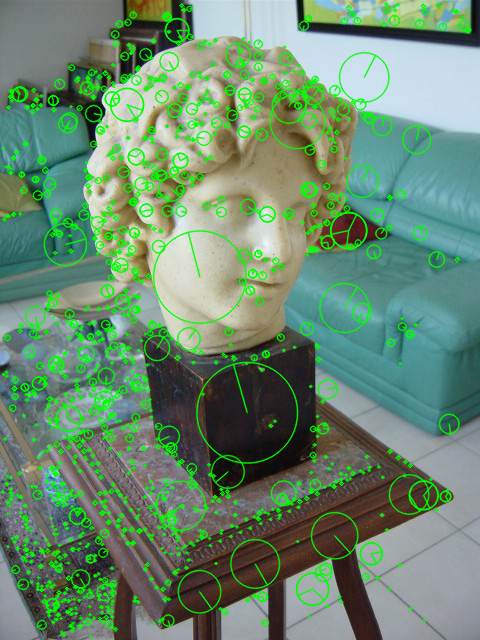

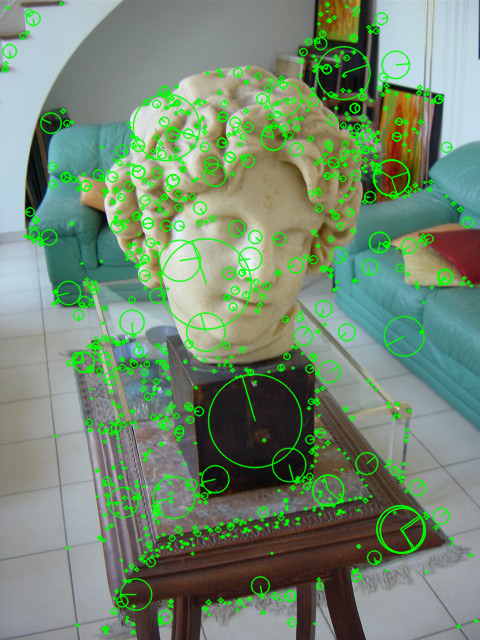

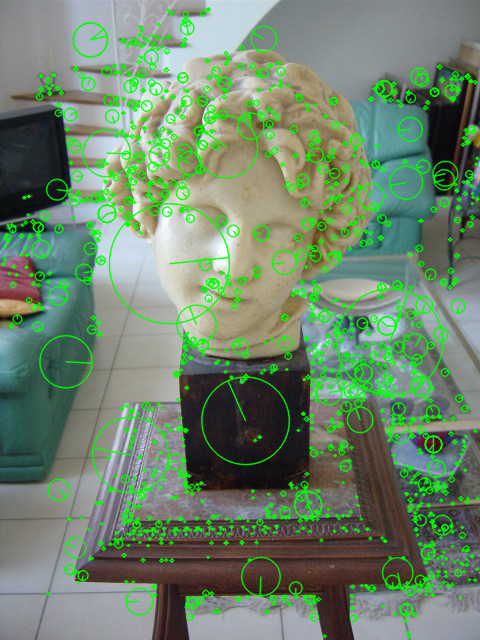

In [5]:
from IPython.display import display, Image
import io

sift = cv2.SIFT_create()
keypoints_list = []
descriptors_list = []

# Iterate through each image to detect keypoints and compute descriptors
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Visualize keypoints on images
keypoints_images = []

for i, image in enumerate(images):
    keypoints_img = cv2.drawKeypoints(image, keypoints_list[i], None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    keypoints_images.append(keypoints_img)

# Display the images with keypoints using IPython.display
for img in keypoints_images:
    img_bytes = cv2.imencode('.png', img)[1].tostring()
    img_display = Image(data=io.BytesIO(img_bytes).read())
    display(img_display)


In [6]:
matcher = cv2.BFMatcher()
matches = [matcher.knnMatch(descriptors_list[i], descriptors_list[i+1], k=2) for i in range(len(descriptors_list)-1)]


In [7]:
print(matches)

[((< cv2.DMatch 0x7d170c5b0870>, < cv2.DMatch 0x7d170c5b13d0>), (< cv2.DMatch 0x7d170c5b0df0>, < cv2.DMatch 0x7d170c5b08f0>), (< cv2.DMatch 0x7d170c5b1370>, < cv2.DMatch 0x7d170c5b09b0>), (< cv2.DMatch 0x7d170c5b0d50>, < cv2.DMatch 0x7d170c5b1410>), (< cv2.DMatch 0x7d170c5b0d10>, < cv2.DMatch 0x7d170c5b0e30>), (< cv2.DMatch 0x7d170c5b1310>, < cv2.DMatch 0x7d170c5b0990>), (< cv2.DMatch 0x7d170c5b13b0>, < cv2.DMatch 0x7d170c5b0dd0>), (< cv2.DMatch 0x7d170c5b1430>, < cv2.DMatch 0x7d170c5b1450>), (< cv2.DMatch 0x7d170c5b1470>, < cv2.DMatch 0x7d170c5b1490>), (< cv2.DMatch 0x7d170c5b14b0>, < cv2.DMatch 0x7d170c5b14d0>), (< cv2.DMatch 0x7d170c5b14f0>, < cv2.DMatch 0x7d170c5b1510>), (< cv2.DMatch 0x7d170c5b1530>, < cv2.DMatch 0x7d170c5b1550>), (< cv2.DMatch 0x7d170c5b1570>, < cv2.DMatch 0x7d170c5b1590>), (< cv2.DMatch 0x7d170c5b15b0>, < cv2.DMatch 0x7d170c5b15d0>), (< cv2.DMatch 0x7d170c5b15f0>, < cv2.DMatch 0x7d170c5b1610>), (< cv2.DMatch 0x7d170c5b1630>, < cv2.DMatch 0x7d170c5b1650>), (< cv2

In [8]:
good_matches = []
for match_list in matches:
    for m, n in match_list:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)


<ipython-input-9-5b0b6dbe5c9e>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_bytes = cv2.imencode('.png', img_matches)[1].tostring()


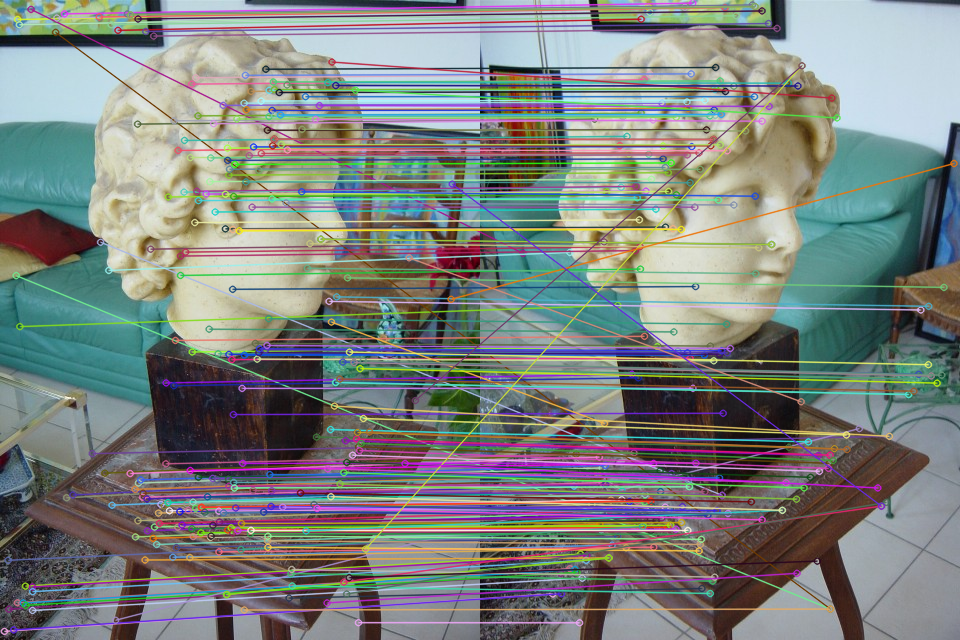

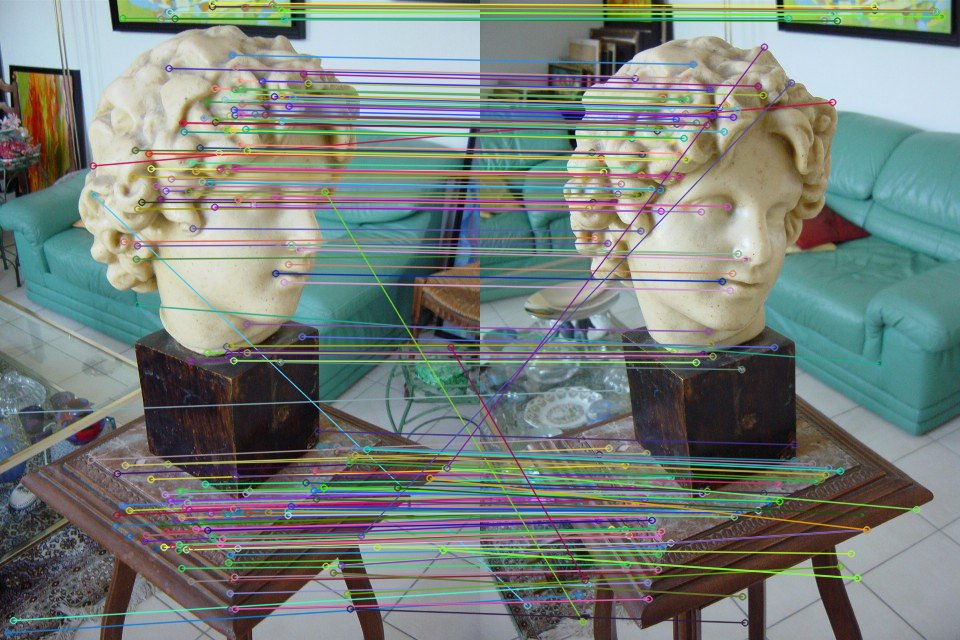

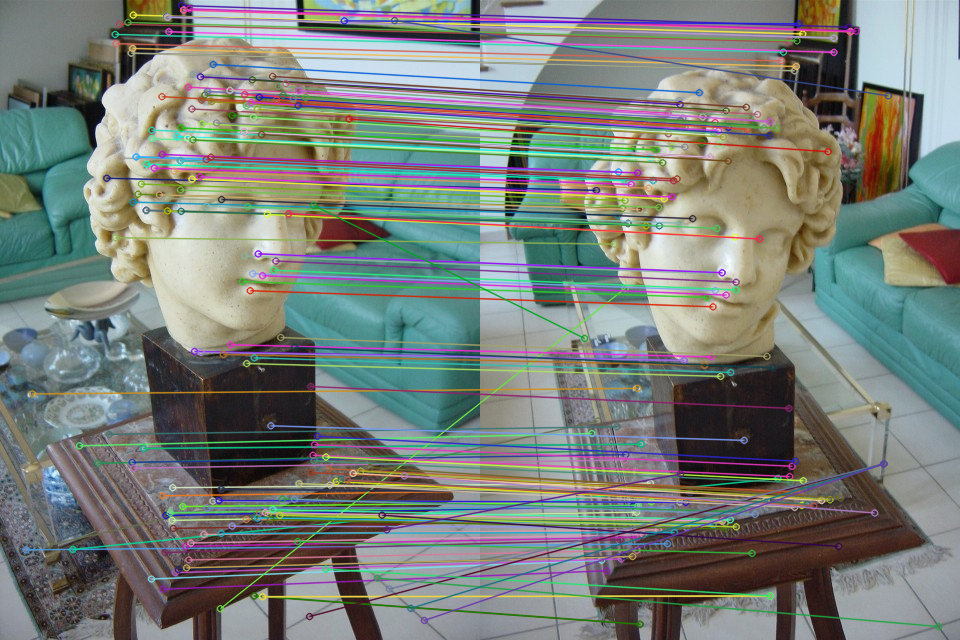

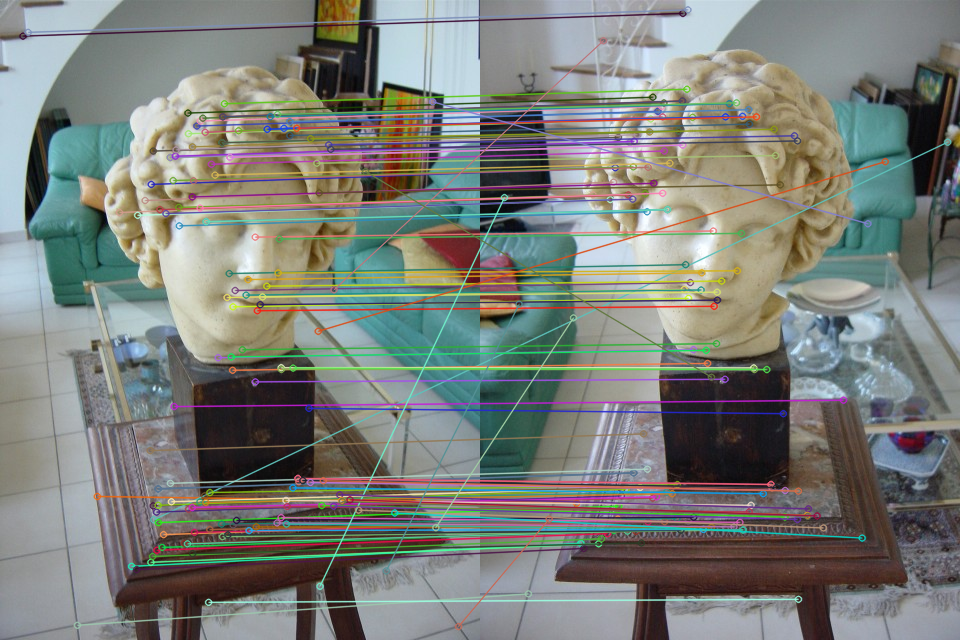

In [9]:
from IPython.display import display, Image
import io

matched_images = []

for i in range(len(images)-1):
    img1 = images[i]
    img2 = images[i+1]
    kp1 = keypoints_list[i]
    kp2 = keypoints_list[i+1]
    matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i+1], k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Convert the image to bytes and display it using IPython.display
    img_bytes = cv2.imencode('.png', img_matches)[1].tostring()
    img_display = Image(data=io.BytesIO(img_bytes).read())
    display(img_display)


In [16]:
import open3d as o3d

# Create a blank canvas to draw the reconstructed bust
canvas_height, canvas_width = images[0].shape[:2]
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Iterate through each pair of consecutive images
for i in range(len(images)-1):
    img1 = images[i]
    img2 = images[i+1]
    kp1 = keypoints_list[i]
    kp2 = keypoints_list[i+1]
    matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i+1], k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Project 3D points onto images to visualize the reconstructed bust
    projected_points = np.array([kp1[m.queryIdx].pt for m in good_matches], dtype=np.float64)
    for point in projected_points:
        x, y = map(int, point)
        cv2.circle(canvas, (x, y), 3, (255, 0, 0), -1)  # Red color

# Save the canvas with the reconstructed bust as an image
cv2.imwrite('reconstructed_bust_nocolor.jpg', canvas)


True

In [13]:
import open3d as o3d

# Create a blank canvas to draw the reconstructed bust
canvas_height, canvas_width = images[0].shape[:2]
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Iterate through each pair of consecutive images
for i in range(len(images)-1):
    img1 = images[i]
    img2 = images[i+1]
    kp1 = keypoints_list[i]
    kp2 = keypoints_list[i+1]
    matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i+1], k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Project 3D points onto images to visualize the reconstructed bust
    for match in good_matches:
        pt1 = kp1[match.queryIdx].pt
        pt2 = kp2[match.trainIdx].pt
        color = img1[int(pt1[1]), int(pt1[0])]  # Get color from img1
        x, y = map(int, pt1)
        cv2.circle(canvas, (x, y), 3, (int(color[0]), int(color[1]), int(color[2])), -1)  # Draw point with actual color

# Save the canvas with the reconstructed bust as an image
cv2.imwrite('reconstructed_bust.jpg', canvas)


True